In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

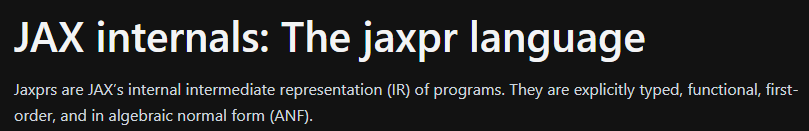

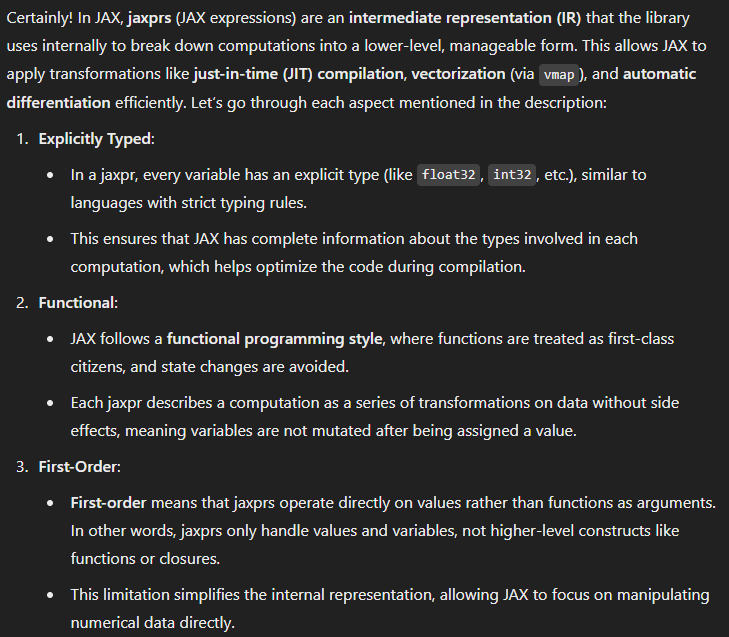

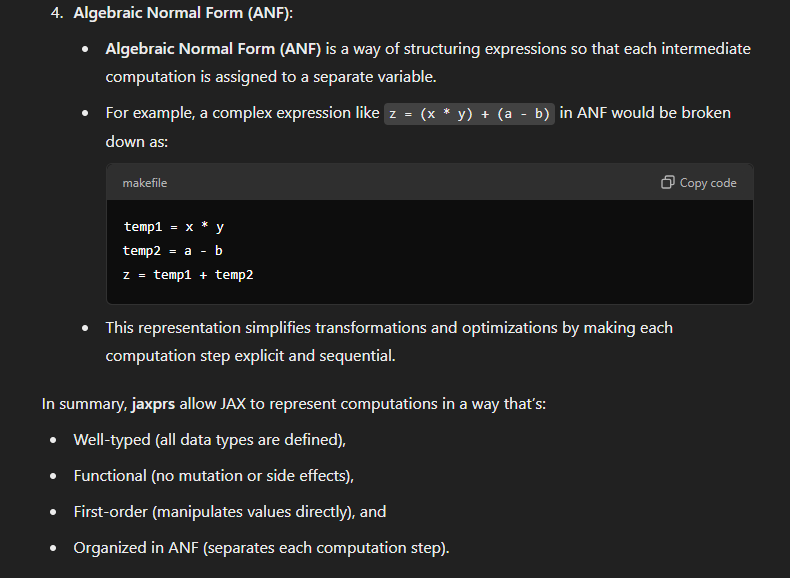

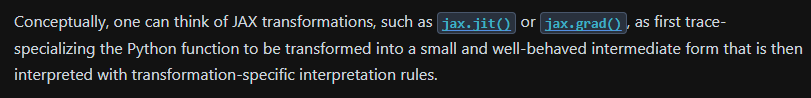

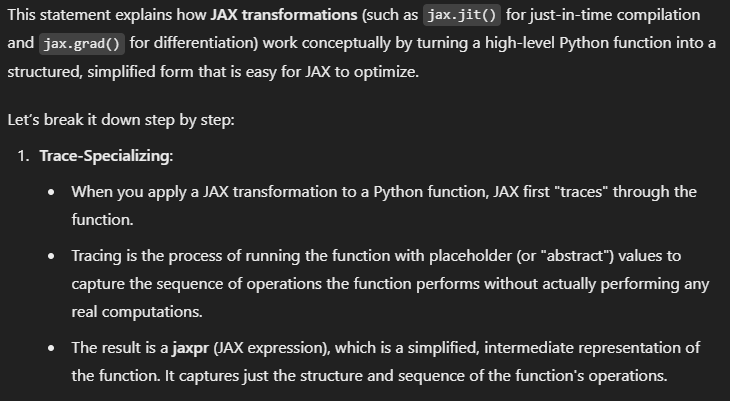

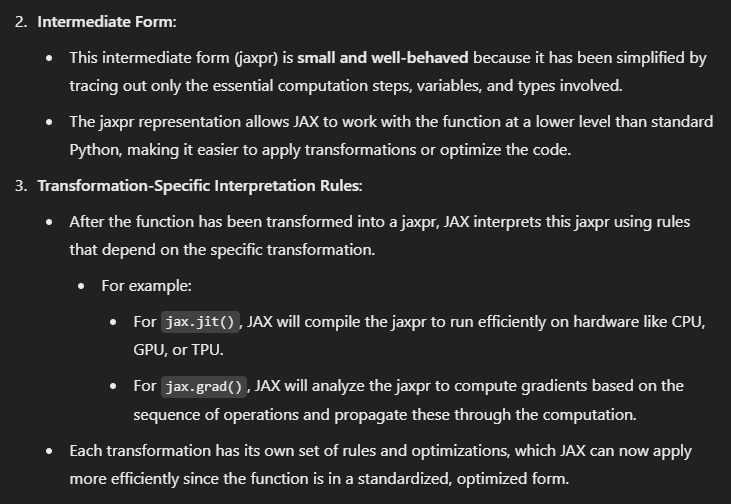

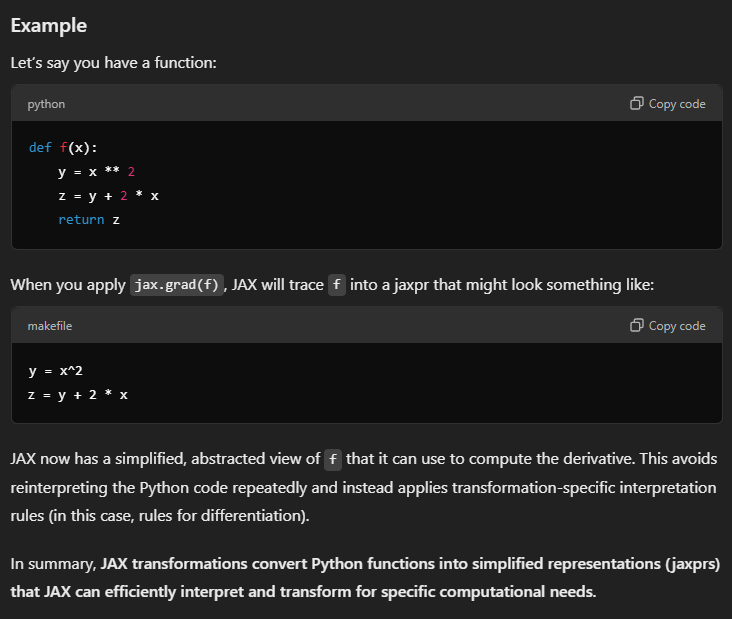

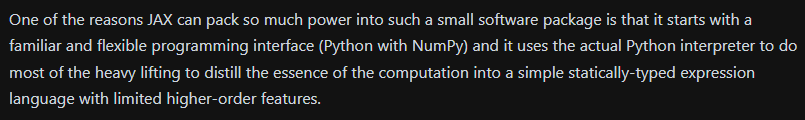

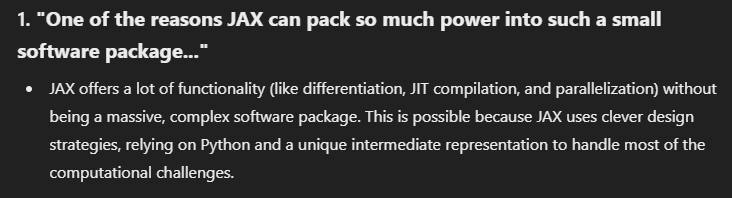

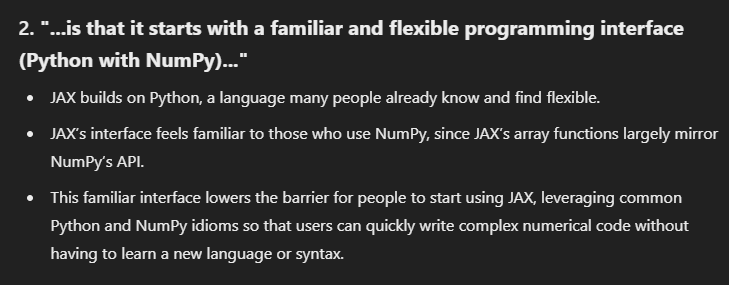

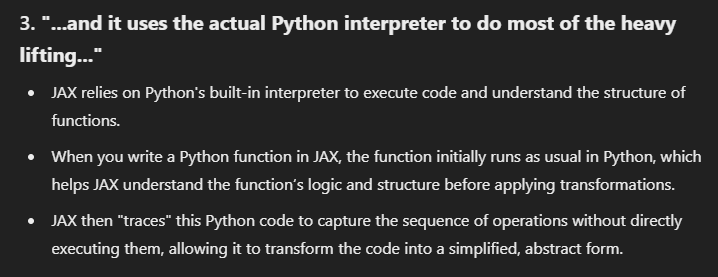

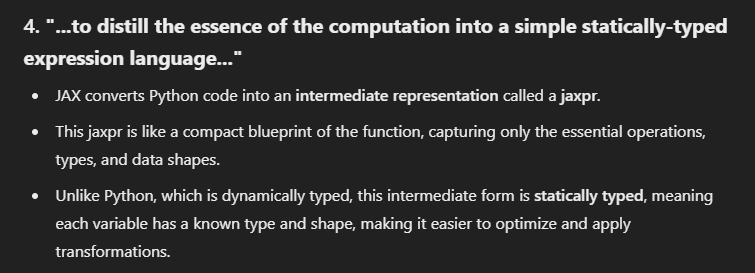

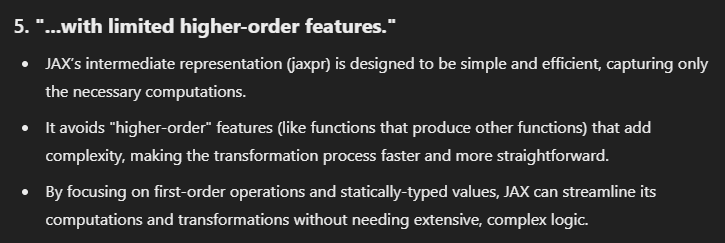

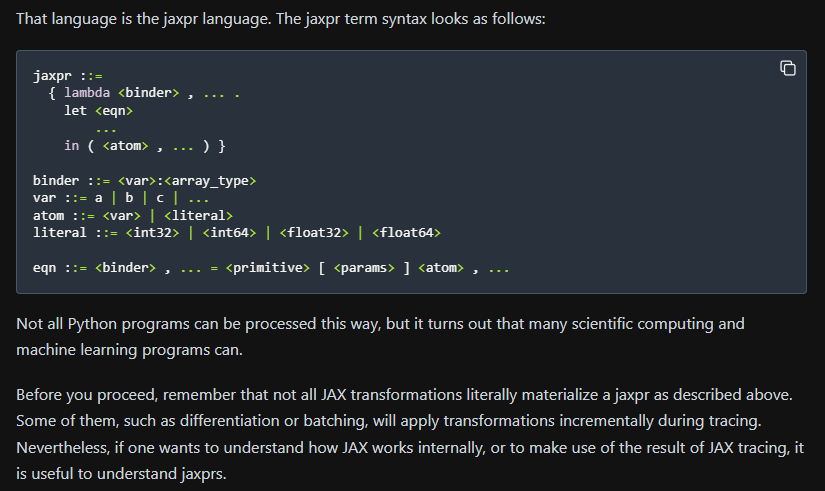

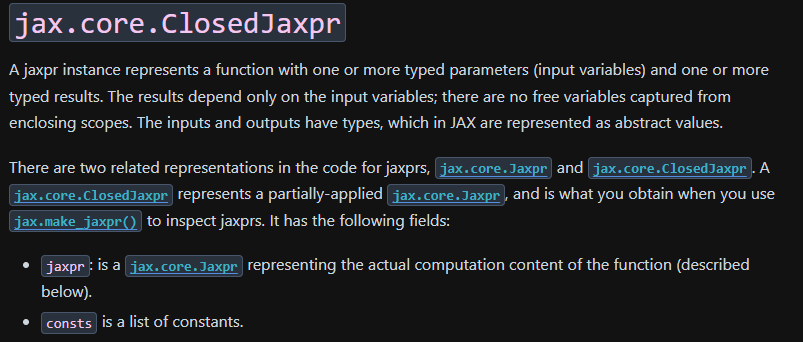

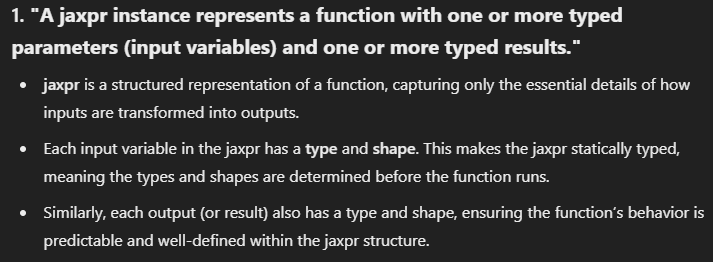

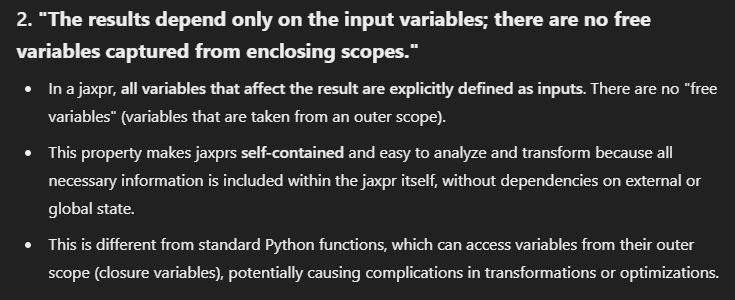

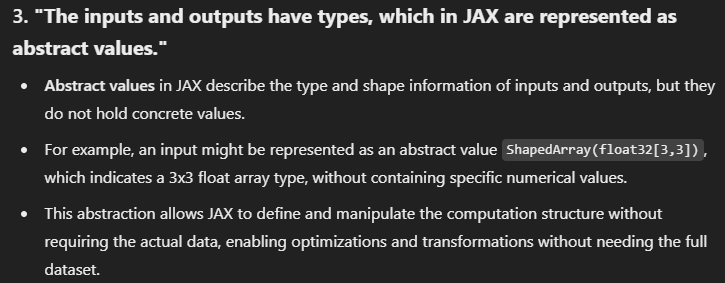

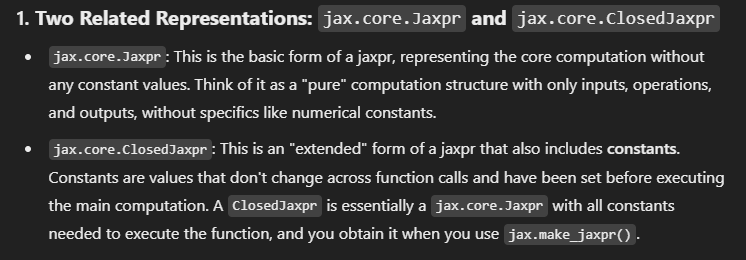

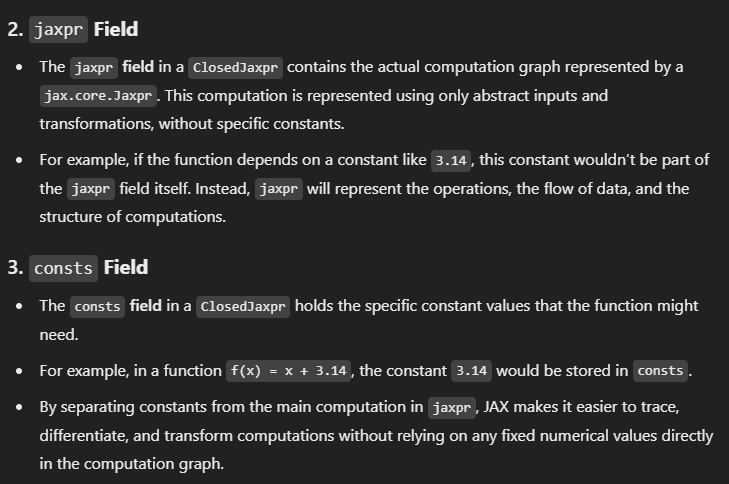

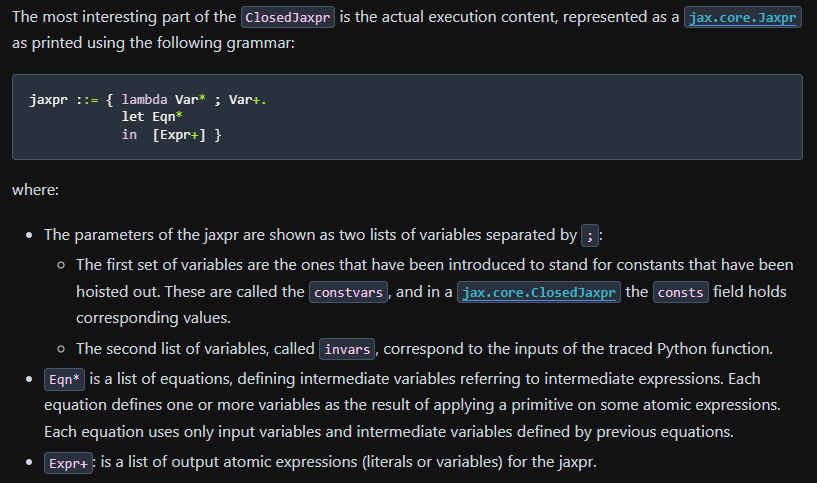

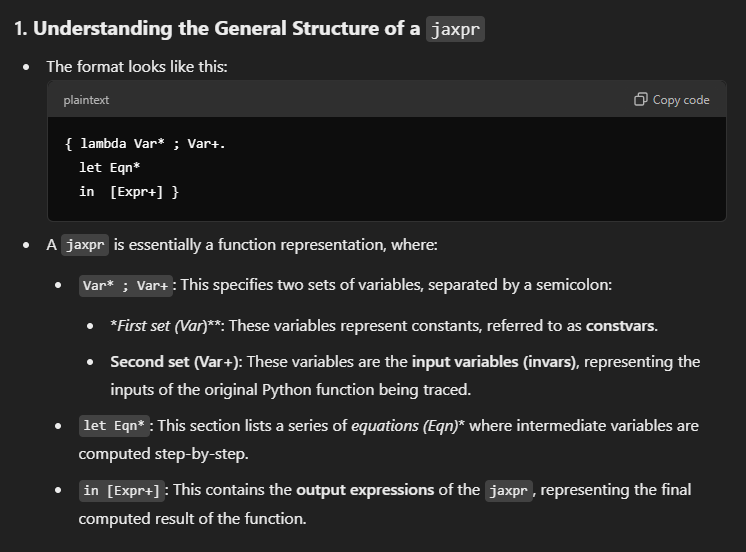

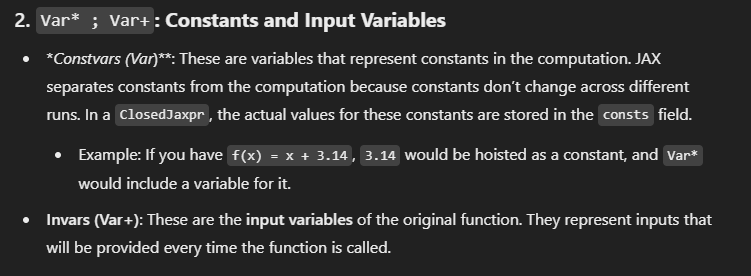

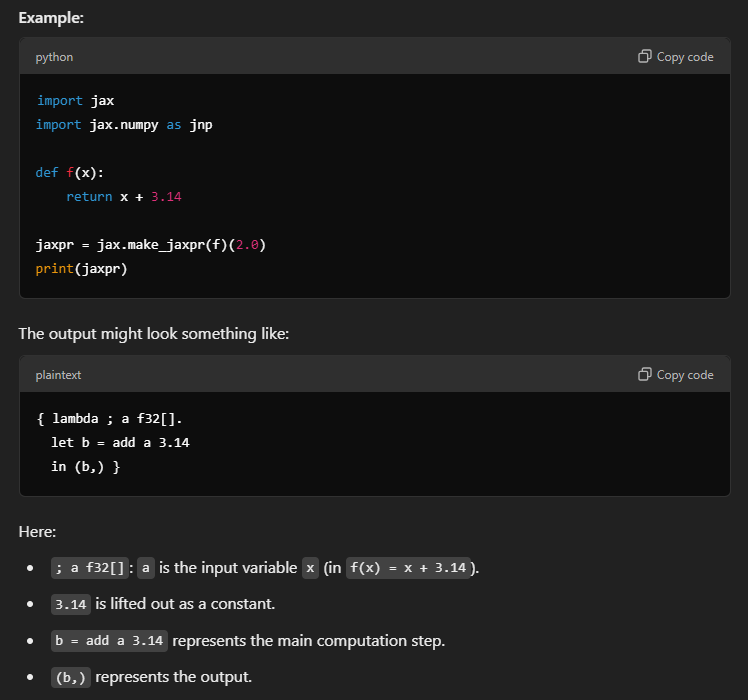

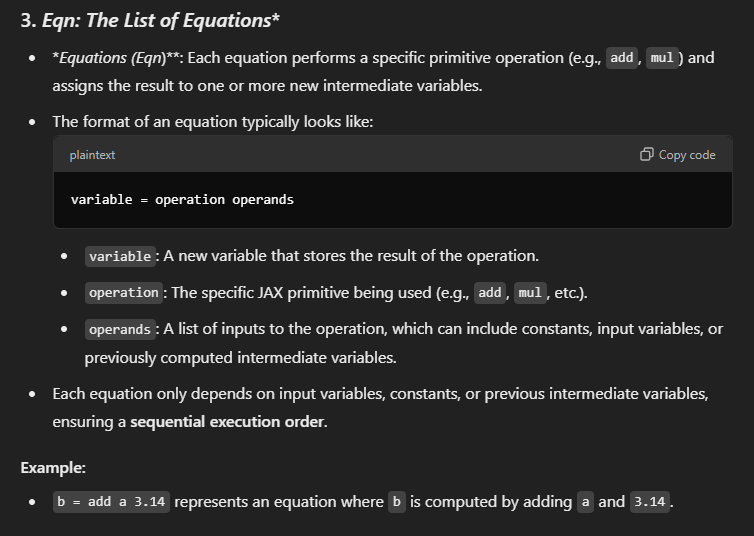
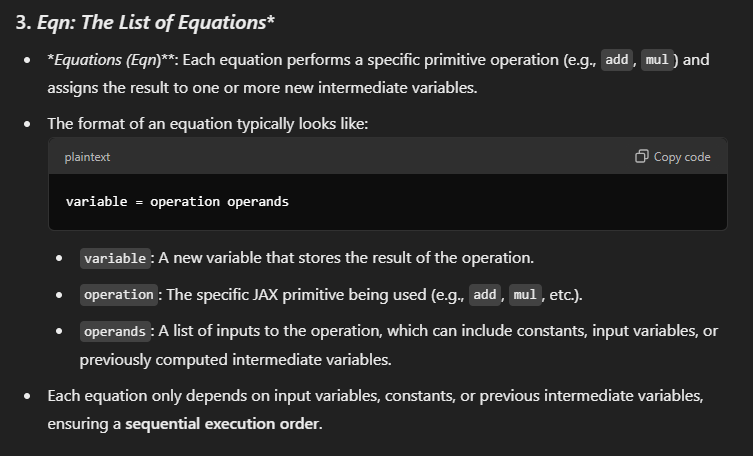

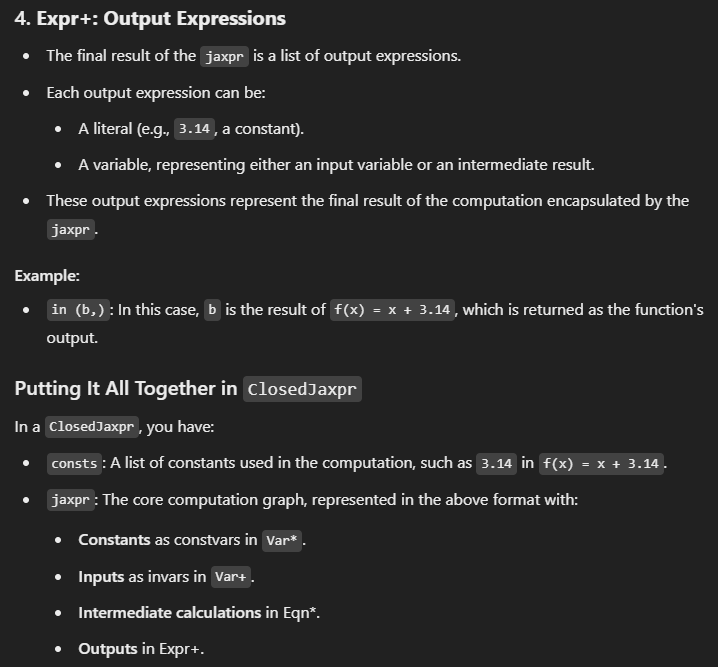

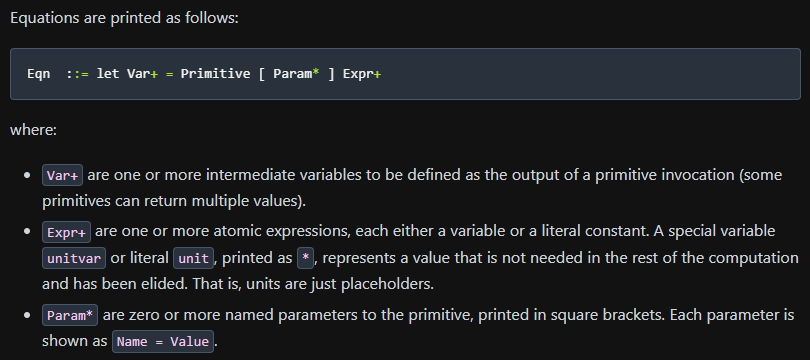

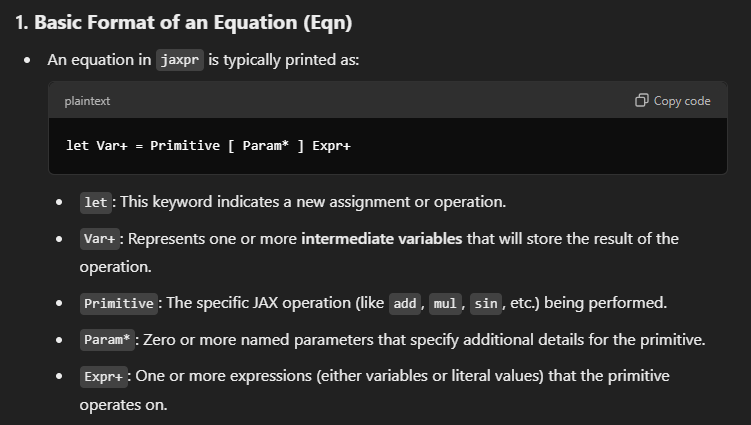

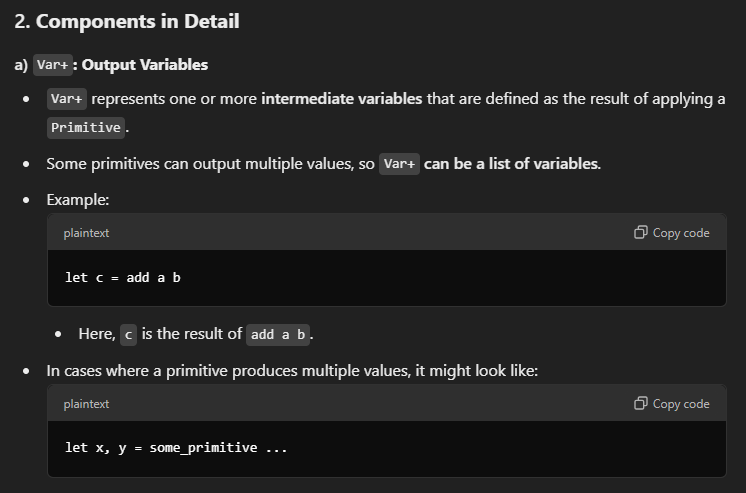

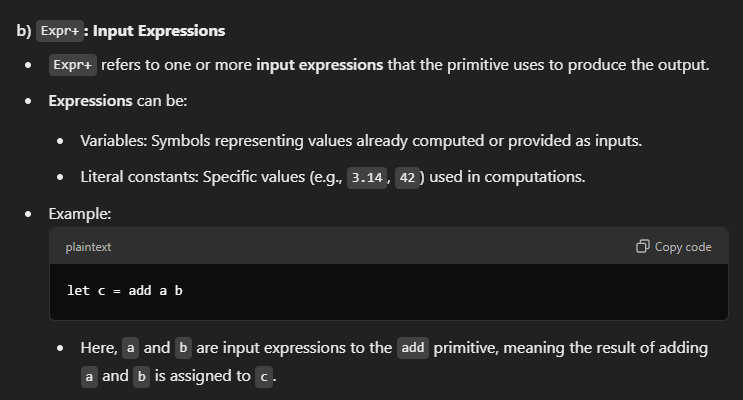

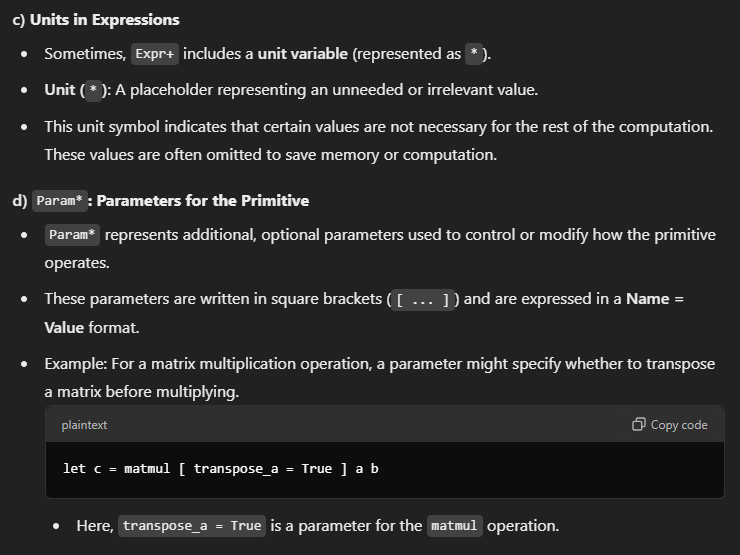

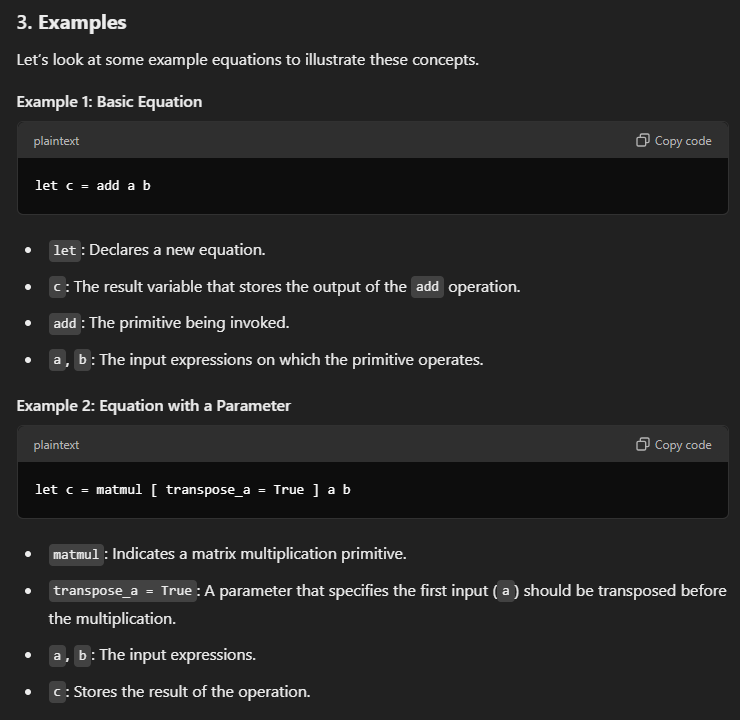

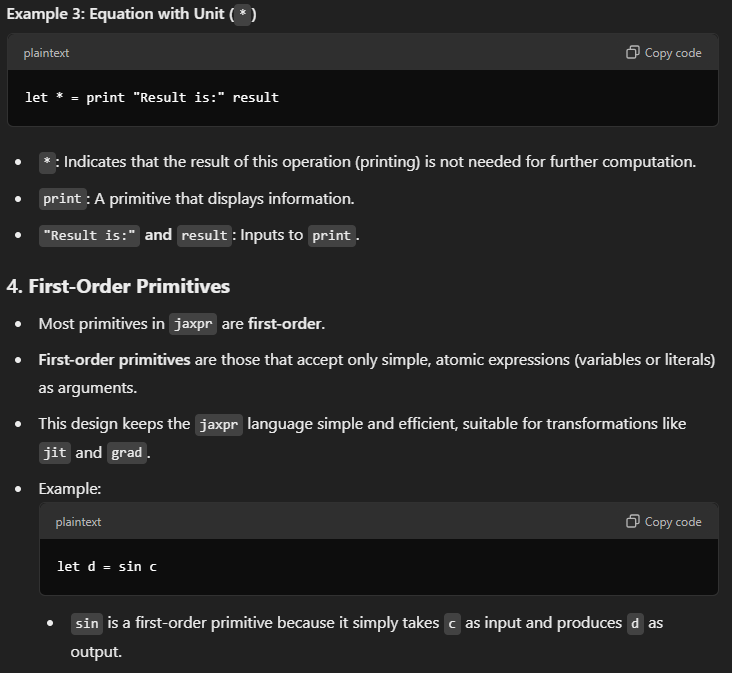

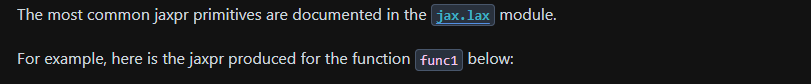

In [2]:
from jax import make_jaxpr
import jax.numpy as jnp

def func1(first, second):
   temp = first + jnp.sin(second) * 3.
   return jnp.sum(temp)

print(make_jaxpr(func1)(jnp.zeros(8), jnp.ones(8)))

{ lambda ; a:f32[8] b:f32[8]. let
    c:f32[8] = sin b
    d:f32[8] = mul c 3.0
    e:f32[8] = add a d
    f:f32[] = reduce_sum[axes=(0,)] e
  in (f,) }


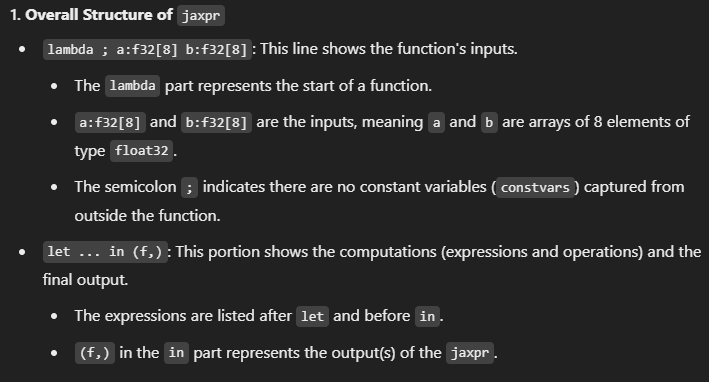

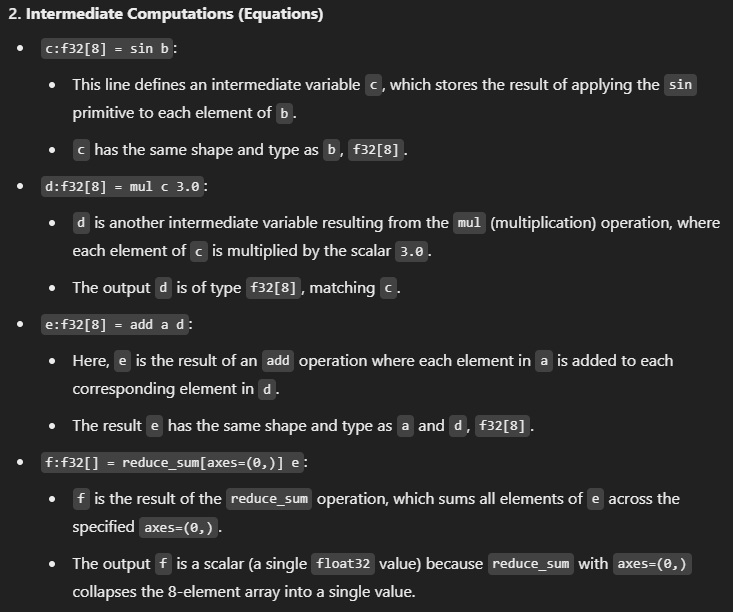

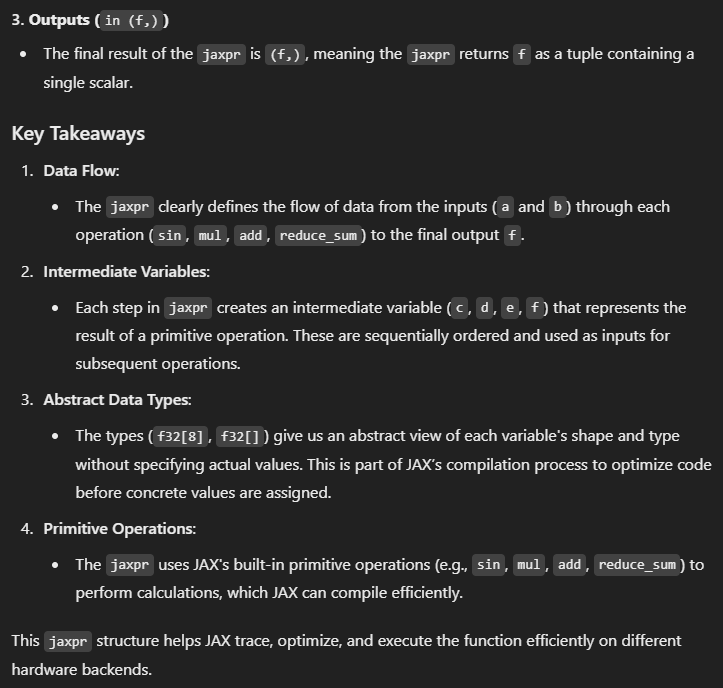

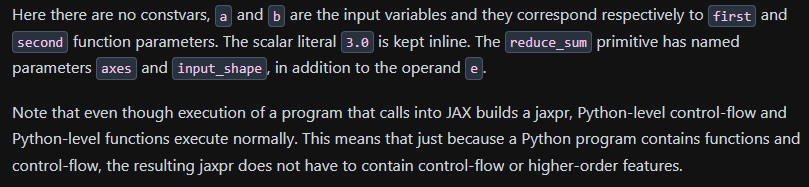

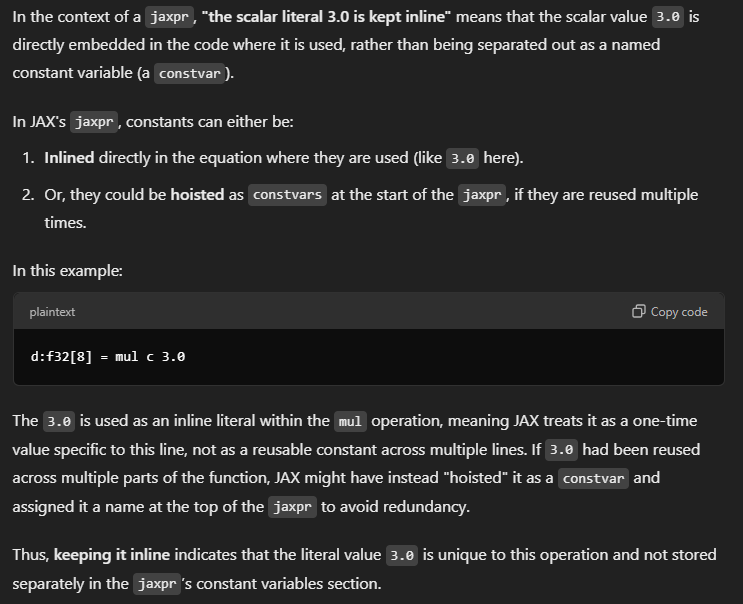

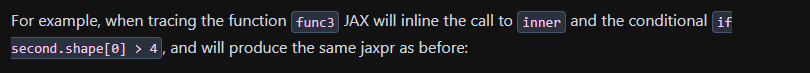

In [3]:
def func2(inner, first, second):
  temp = first + inner(second) * 3.
  return jnp.sum(temp)

def inner(second):
  if second.shape[0] > 4:
    return jnp.sin(second)
  else:
    assert False

def func3(first, second):
  return func2(inner, first, second)

print(make_jaxpr(func3)(jnp.zeros(8), jnp.ones(8)))

{ lambda ; a:f32[8] b:f32[8]. let
    c:f32[8] = sin b
    d:f32[8] = mul c 3.0
    e:f32[8] = add a d
    f:f32[] = reduce_sum[axes=(0,)] e
  in (f,) }


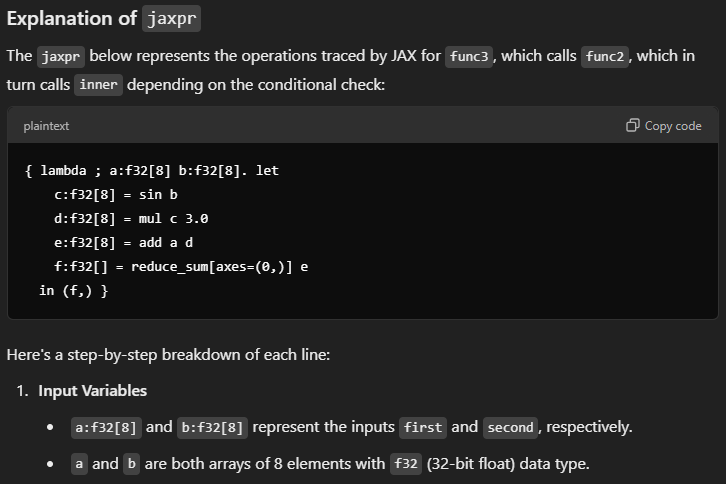

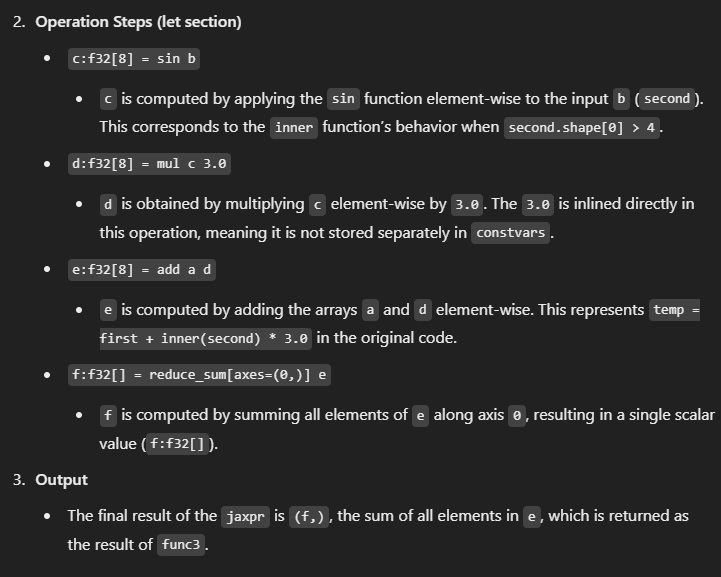

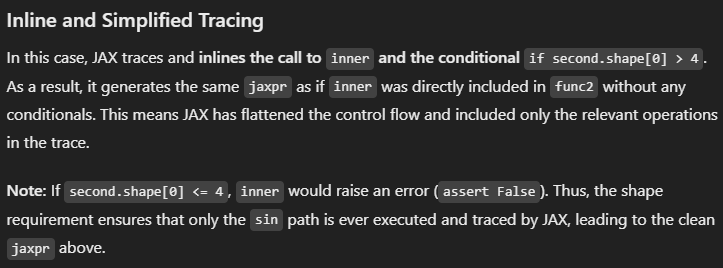

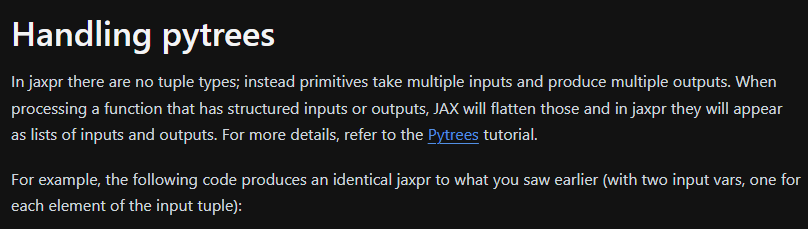

In [4]:
def func4(arg):  # The `arg` is a pair.
  temp = arg[0] + jnp.sin(arg[1]) * 3.
  return jnp.sum(temp)

print(make_jaxpr(func4)((jnp.zeros(8), jnp.ones(8))))

{ lambda ; a:f32[8] b:f32[8]. let
    c:f32[8] = sin b
    d:f32[8] = mul c 3.0
    e:f32[8] = add a d
    f:f32[] = reduce_sum[axes=(0,)] e
  in (f,) }


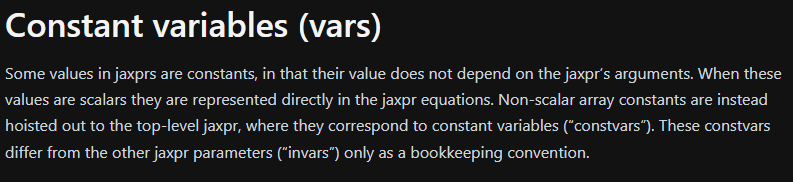

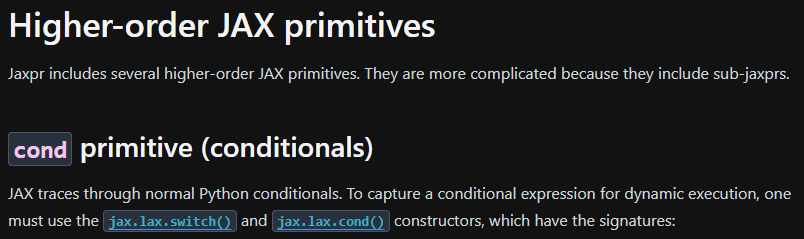

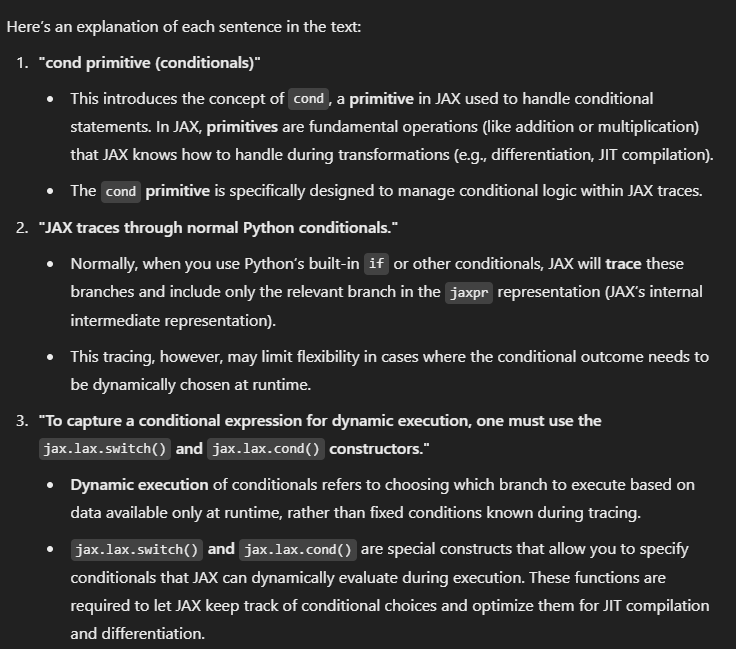

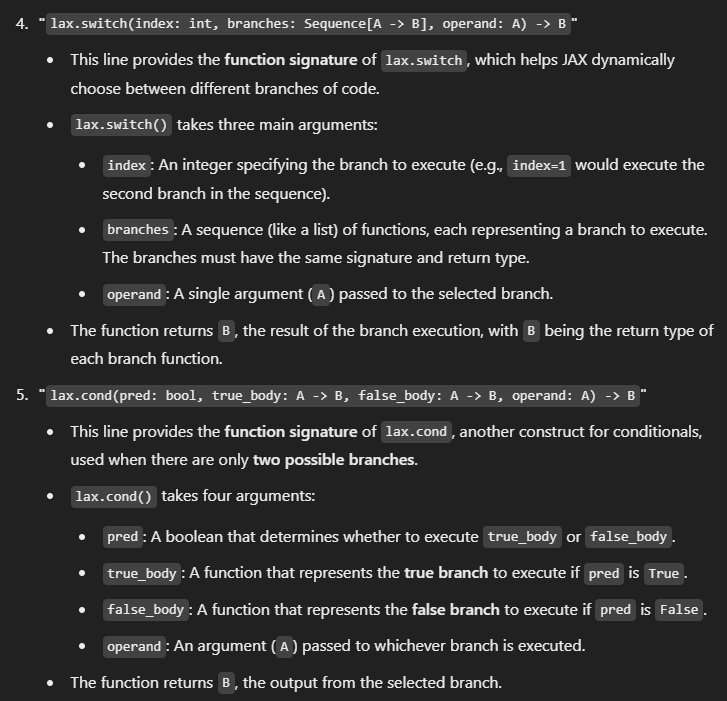

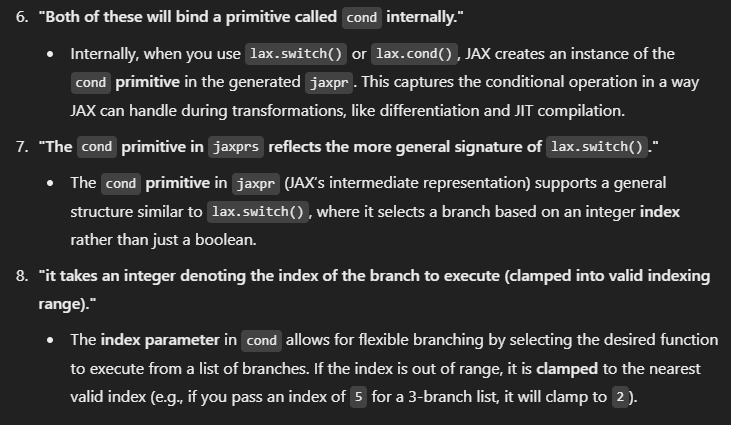

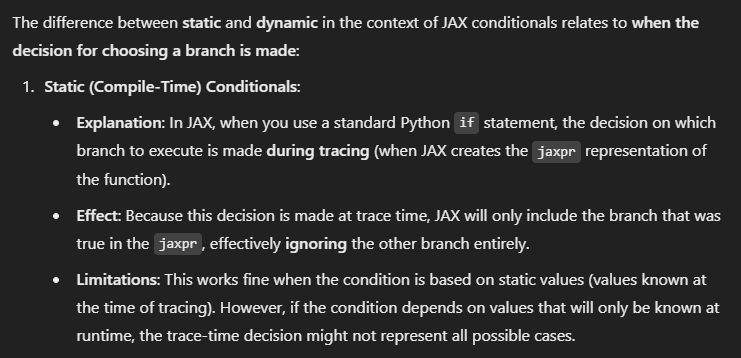

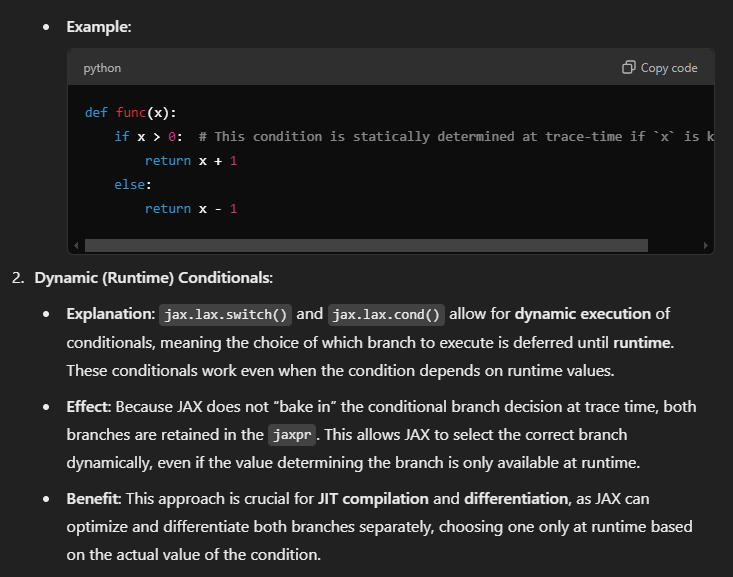

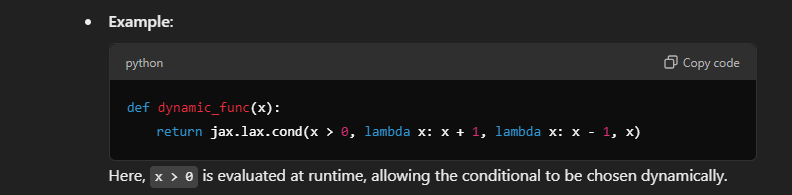

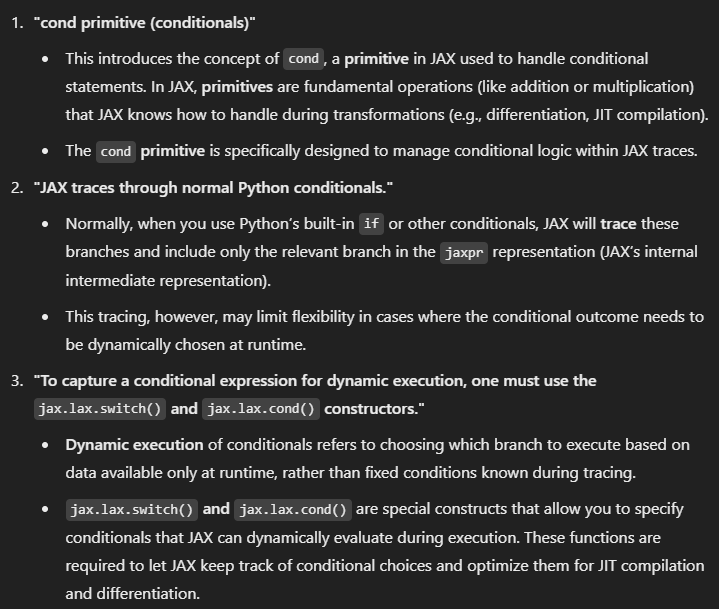

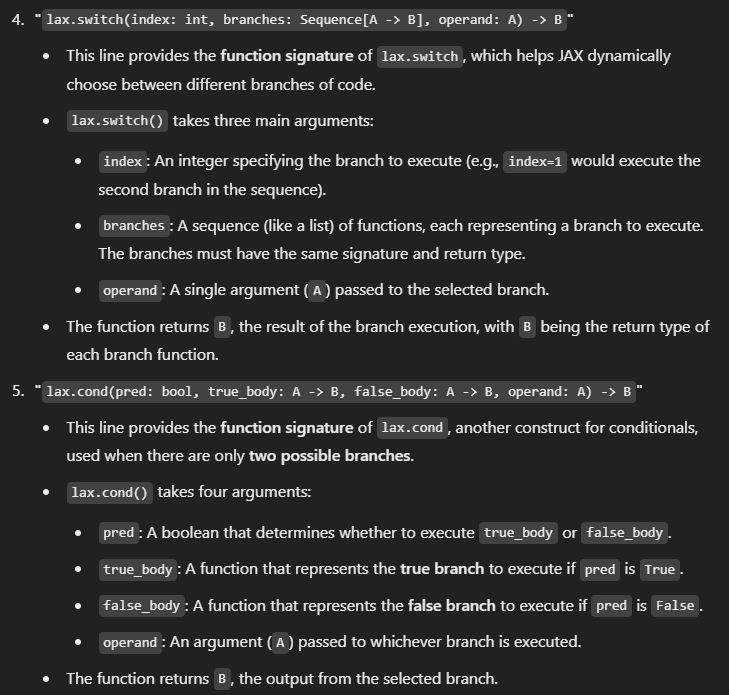

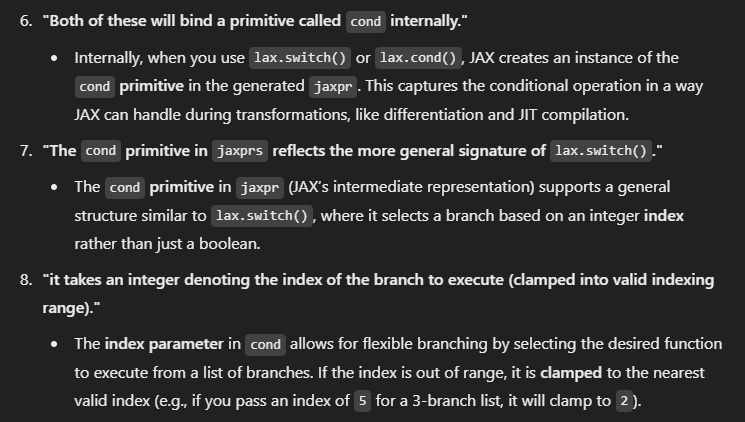

In [6]:
from jax import lax

def one_of_three(index, arg):
  return lax.switch(index, [lambda x: x + 1.,
                            lambda x: x - 2.,
                            lambda x: x + 3.],
                    arg)

print(make_jaxpr(one_of_three)(1, 5.))

{ lambda ; a:i32[] b:f32[]. let
    c:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    d:i32[] = clamp 0 c 2
    e:f32[] = cond[
      branches=(
        { lambda ; f:f32[]. let g:f32[] = add f 1.0 in (g,) }
        { lambda ; h:f32[]. let i:f32[] = sub h 2.0 in (i,) }
        { lambda ; j:f32[]. let k:f32[] = add j 3.0 in (k,) }
      )
      linear=(False,)
    ] d b
  in (e,) }


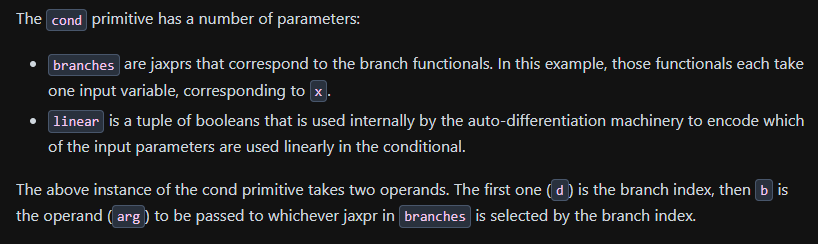

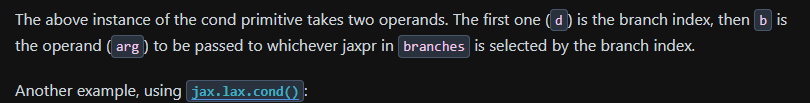

In [7]:
from jax import lax

def func7(arg):
  return lax.cond(arg >= 0.,
                  lambda xtrue: xtrue + 3.,
                  lambda xfalse: xfalse - 3.,
                  arg)

print(make_jaxpr(func7)(5.))

{ lambda ; a:f32[]. let
    b:bool[] = ge a 0.0
    c:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    d:f32[] = cond[
      branches=(
        { lambda ; e:f32[]. let f:f32[] = sub e 3.0 in (f,) }
        { lambda ; g:f32[]. let h:f32[] = add g 3.0 in (h,) }
      )
      linear=(False,)
    ] c a
  in (d,) }


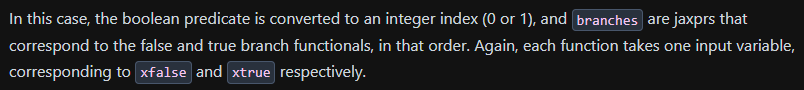

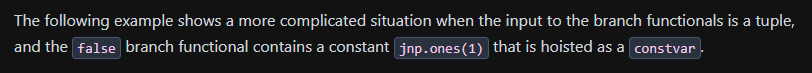

In [8]:
def func8(arg1, arg2):  # Where `arg2` is a pair.
  return lax.cond(arg1 >= 0.,
                  lambda xtrue: xtrue[0],
                  lambda xfalse: jnp.array([1]) + xfalse[1],
                  arg2)

print(make_jaxpr(func8)(5., (jnp.zeros(1), 2.)))

{ lambda a:i32[1]; b:f32[] c:f32[1] d:f32[]. let
    e:bool[] = ge b 0.0
    f:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
    g:f32[1] = cond[
      branches=(
        { lambda ; h:i32[1] i:f32[1] j:f32[]. let
            k:f32[1] = convert_element_type[new_dtype=float32 weak_type=True] h
            l:f32[1] = add k j
          in (l,) }
        { lambda ; m_:i32[1] n:f32[1] o:f32[]. let  in (n,) }
      )
      linear=(False, False, False)
    ] f a c d
  in (g,) }


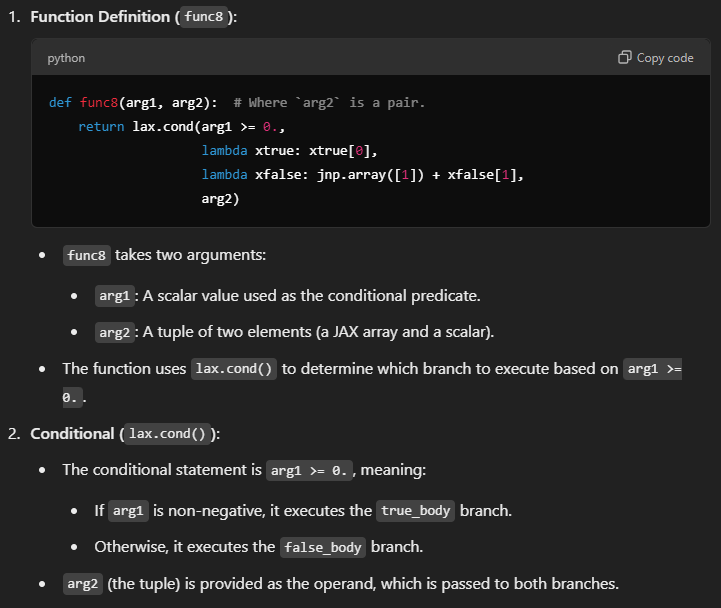

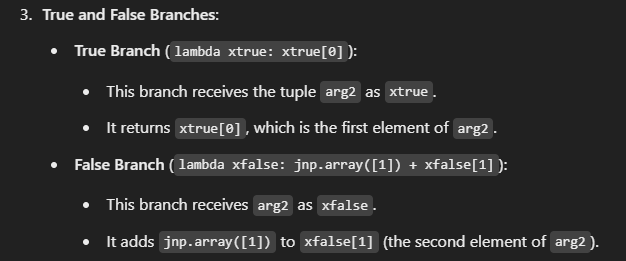

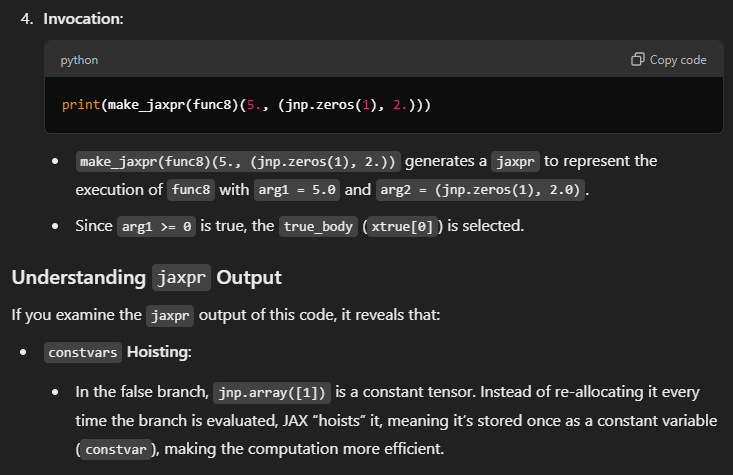

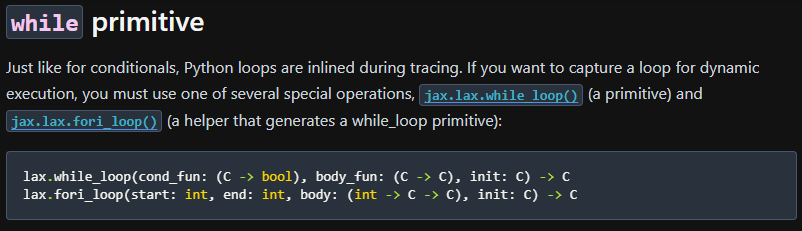

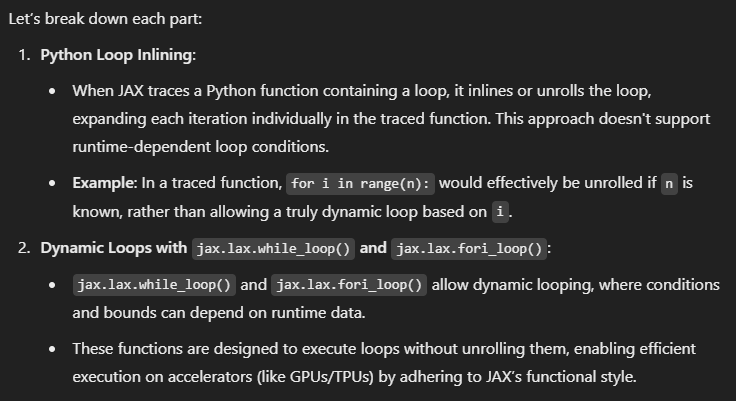

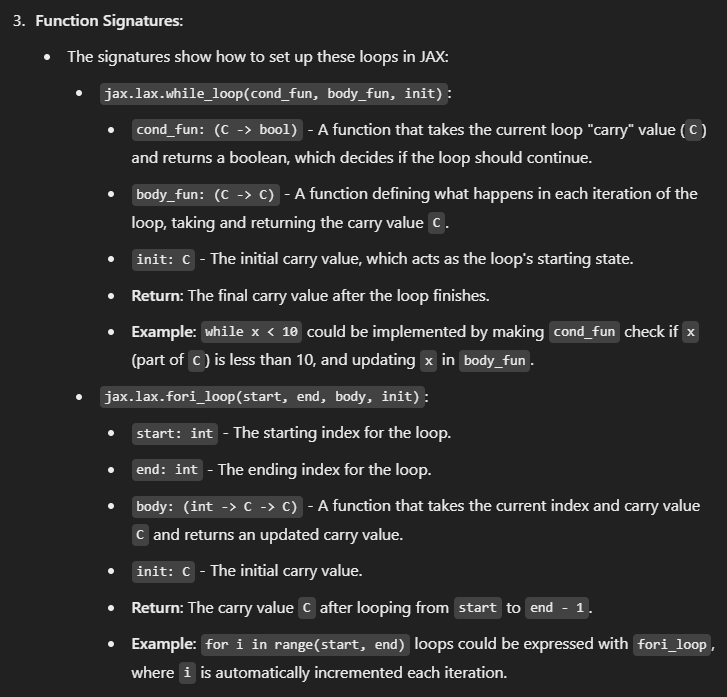

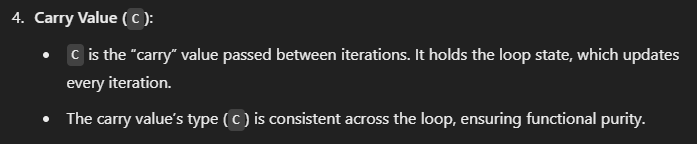

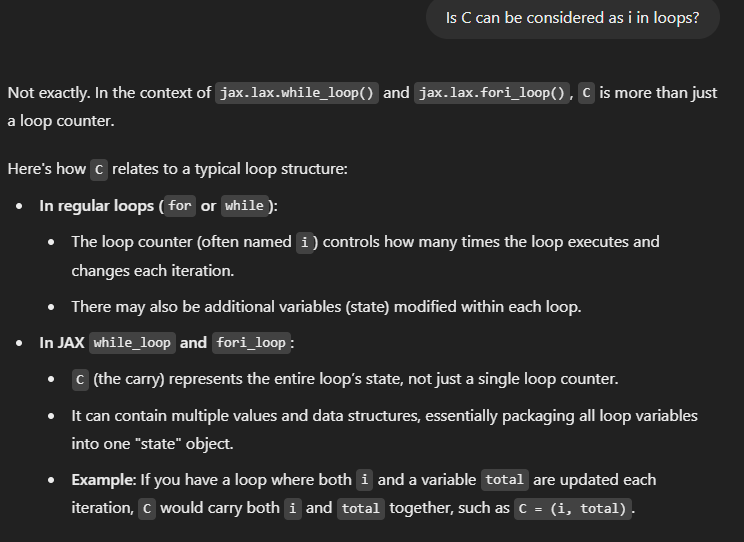

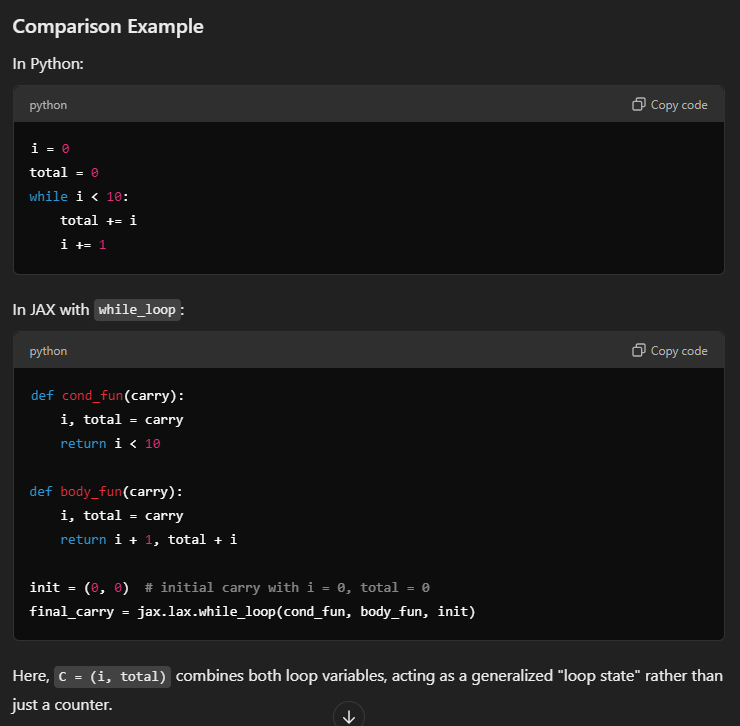

In [9]:
import numpy as np

def func10(arg, n):
  ones = jnp.ones(arg.shape)  # A constant.
  return lax.fori_loop(0, n,
                       lambda i, carry: carry + ones * 3. + arg,
                       arg + ones)

print(make_jaxpr(func10)(np.ones(16), 5))

{ lambda ; a:f32[16] b:i32[]. let
    c:f32[16] = broadcast_in_dim[broadcast_dimensions=() shape=(16,)] 1.0
    d:f32[16] = add a c
    _:i32[] _:i32[] e:f32[16] = while[
      body_jaxpr={ lambda ; f:f32[16] g:f32[16] h:i32[] i:i32[] j:f32[16]. let
          k:i32[] = add h 1
          l:f32[16] = mul f 3.0
          m:f32[16] = add j l
          n:f32[16] = add m g
        in (k, i, n) }
      body_nconsts=2
      cond_jaxpr={ lambda ; o:i32[] p:i32[] q:f32[16]. let
          r:bool[] = lt o p
        in (r,) }
      cond_nconsts=0
    ] c a 0 b d
  in (e,) }


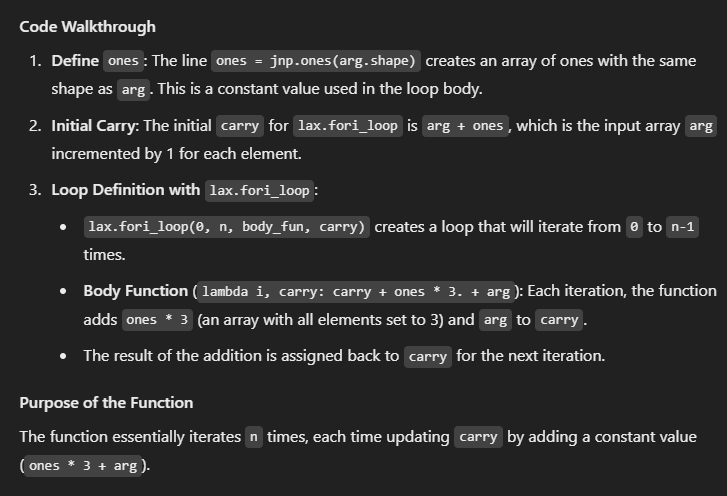

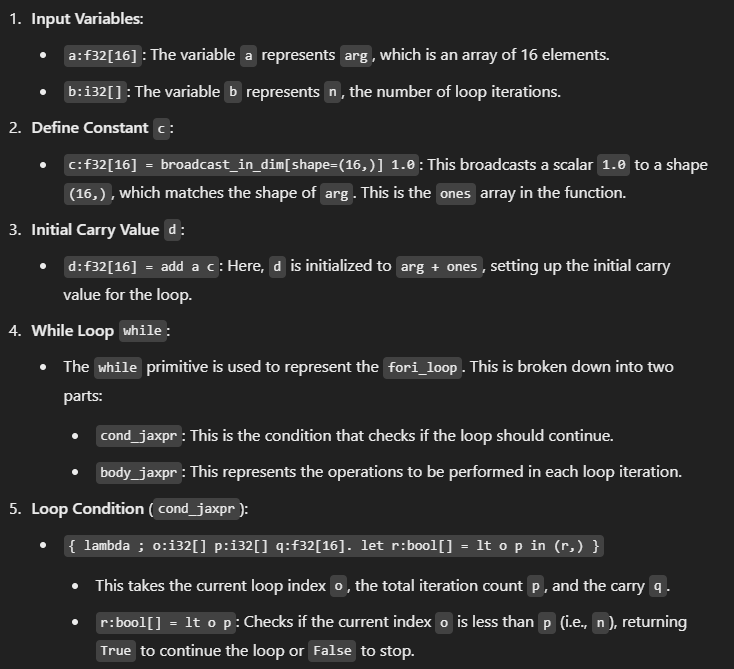

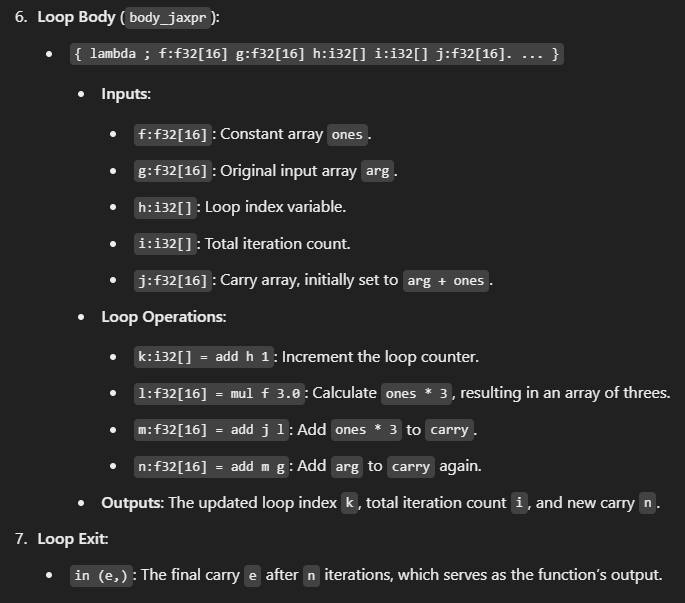

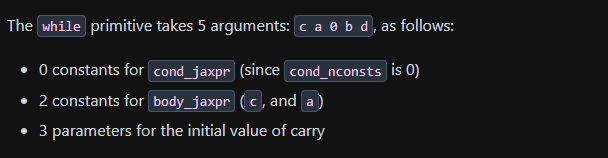

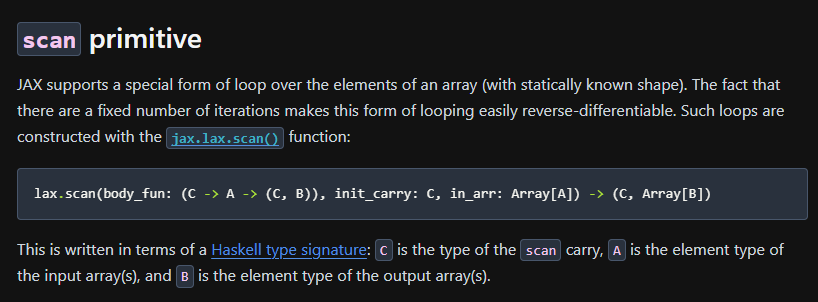
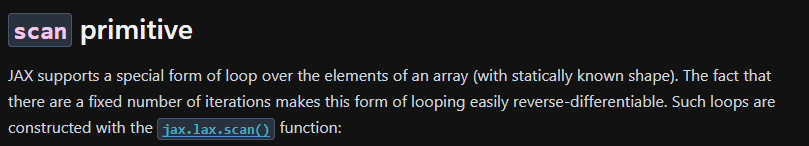

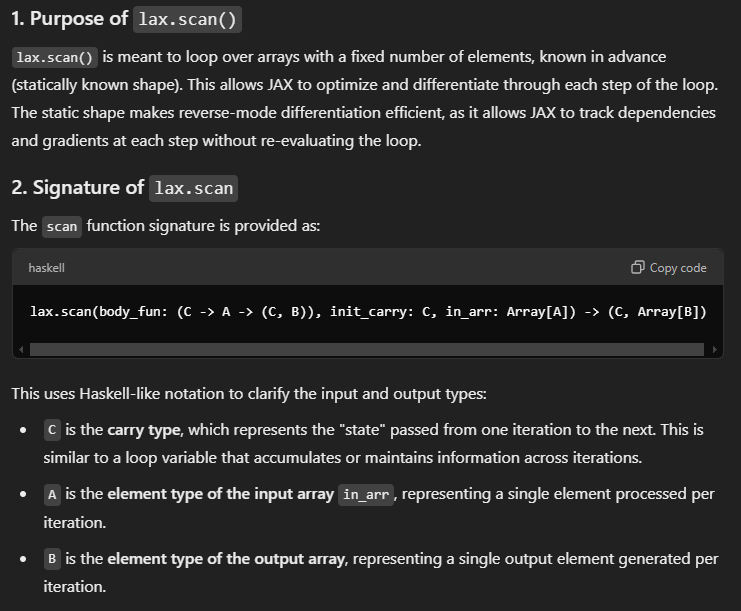

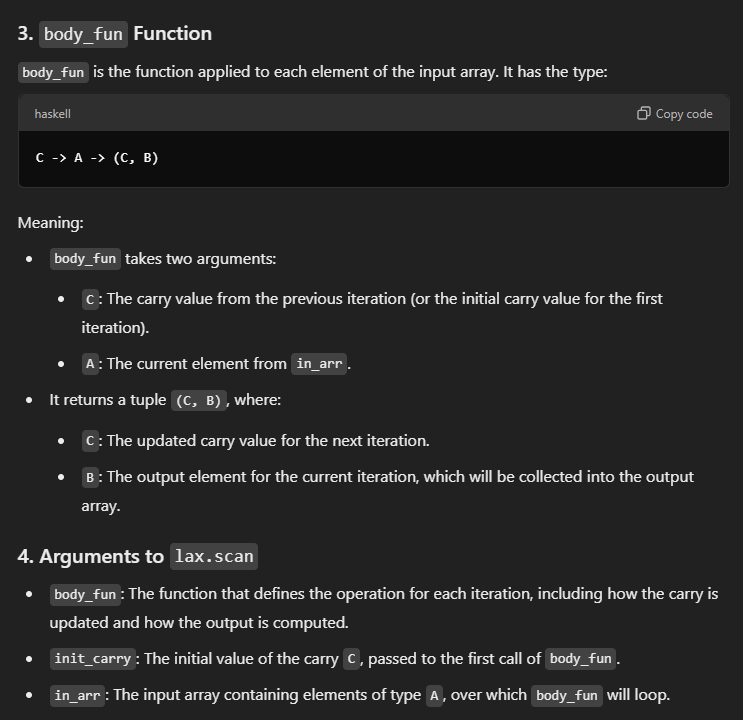

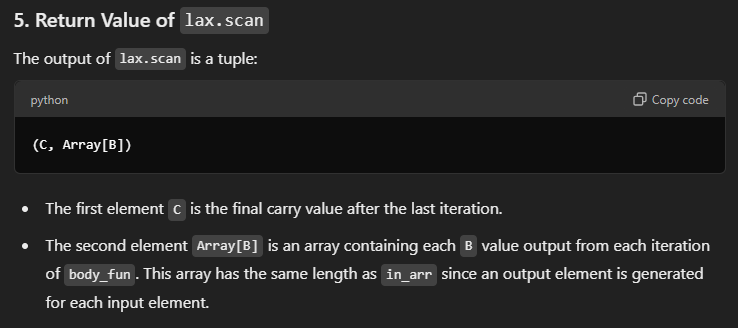

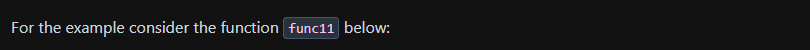

In [10]:
def func11(arr, extra):
  ones = jnp.ones(arr.shape)  #  A constant
  def body(carry, aelems):
    # carry: running dot-product of the two arrays
    # aelems: a pair with corresponding elements from the two arrays
    ae1, ae2 = aelems
    return (carry + ae1 * ae2 + extra, carry)
  return lax.scan(body, 0., (arr, ones))

print(make_jaxpr(func11)(np.ones(16), 5.))

{ lambda ; a:f32[16] b:f32[]. let
    c:f32[16] = broadcast_in_dim[broadcast_dimensions=() shape=(16,)] 1.0
    d:f32[] e:f32[16] = scan[
      _split_transpose=False
      jaxpr={ lambda ; f:f32[] g:f32[] h:f32[] i:f32[]. let
          j:f32[] = mul h i
          k:f32[] = convert_element_type[new_dtype=float32 weak_type=False] g
          l:f32[] = add k j
          m:f32[] = convert_element_type[new_dtype=float32 weak_type=False] f
          n:f32[] = add l m
        in (n, g) }
      length=16
      linear=(False, False, False, False)
      num_carry=1
      num_consts=1
      reverse=False
      unroll=1
    ] b 0.0 a c
  in (d, e) }


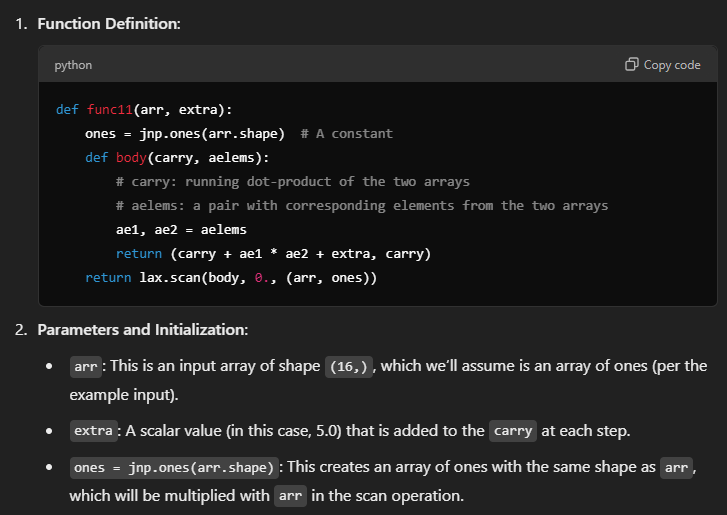

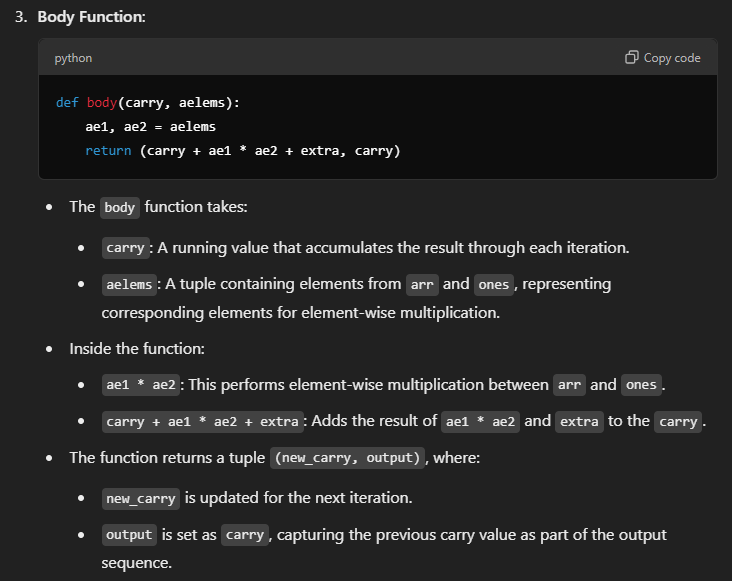

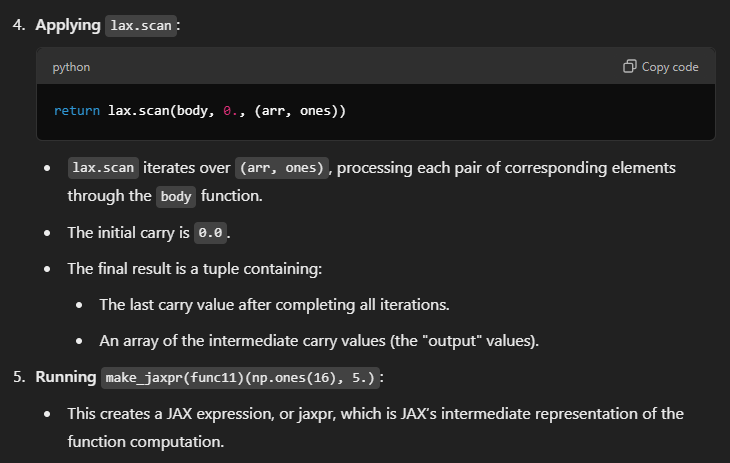

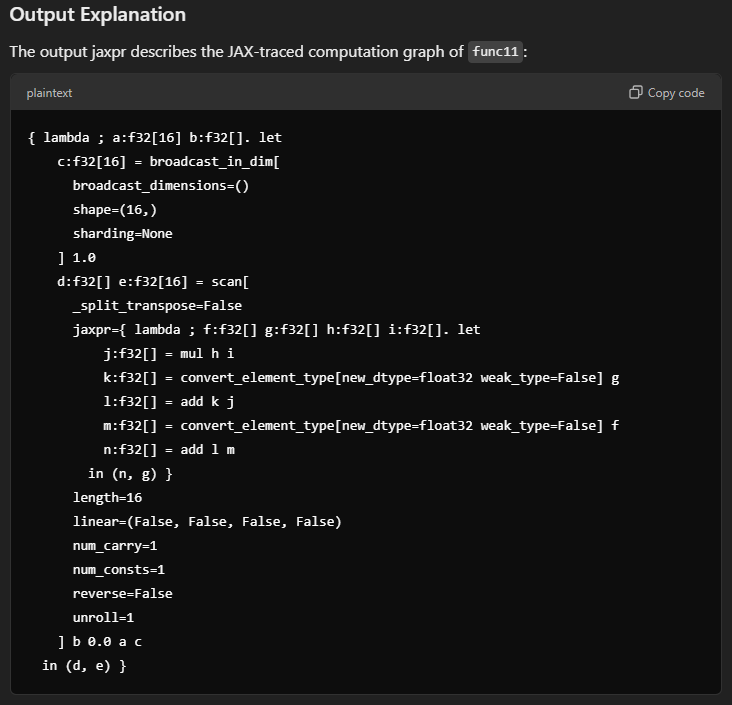

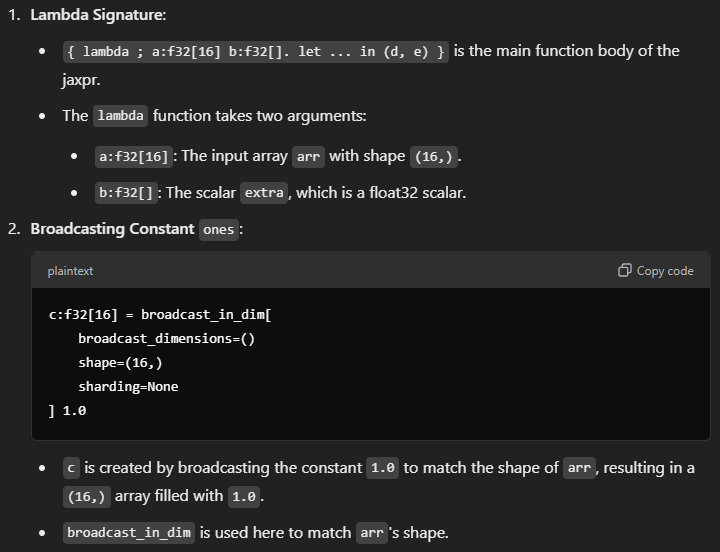

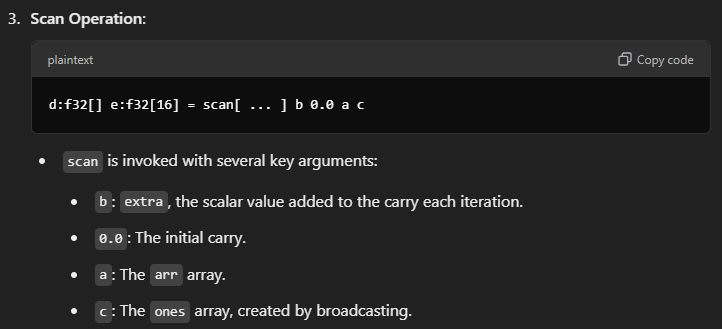

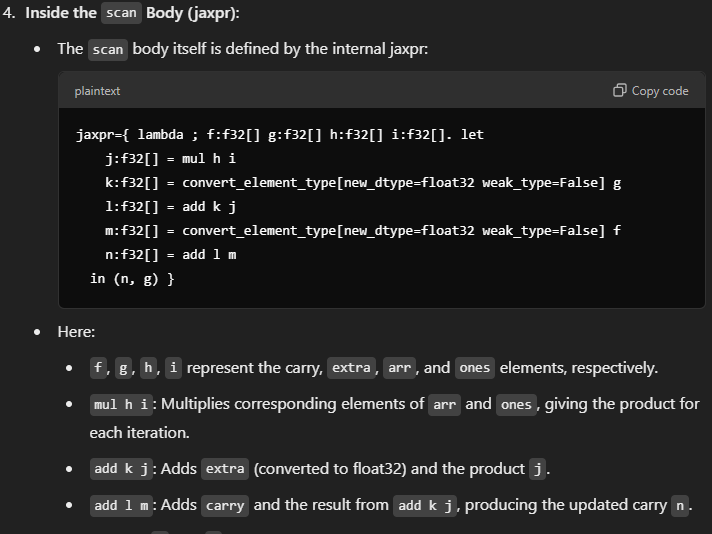

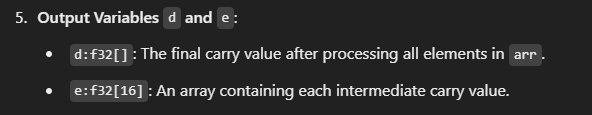

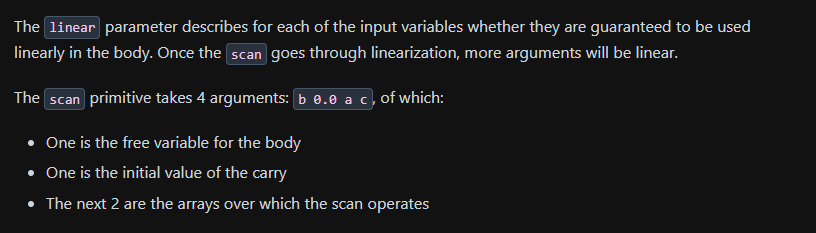

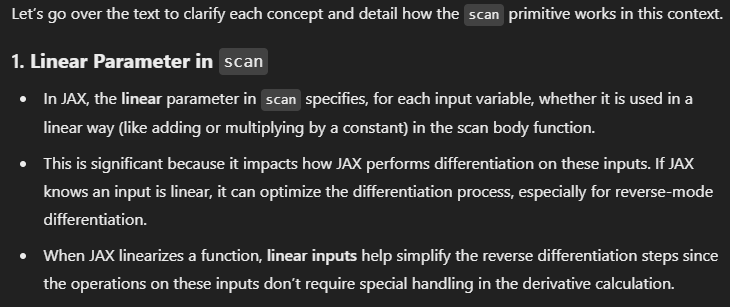

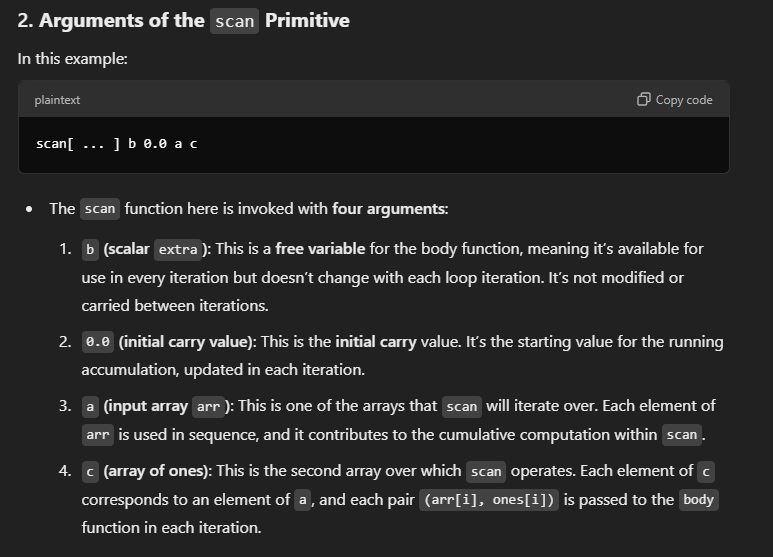

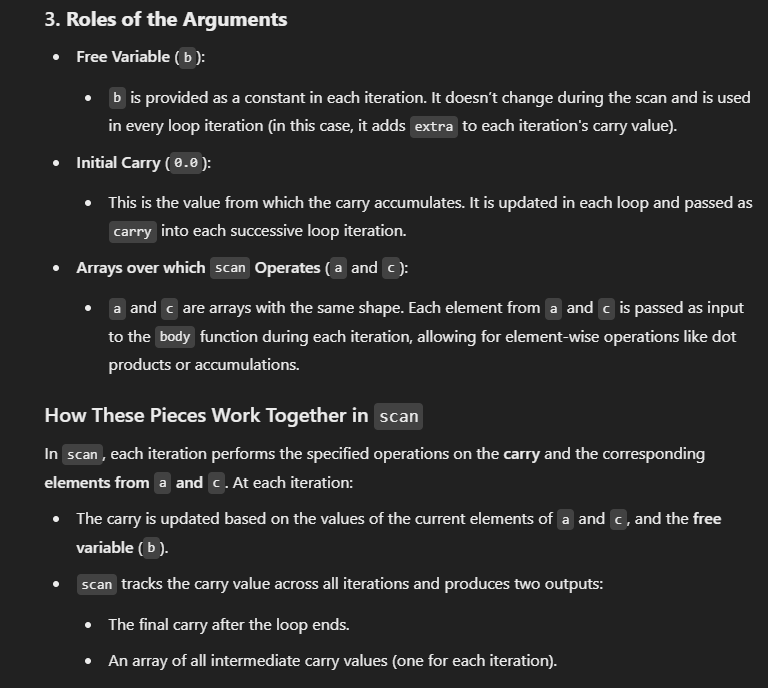

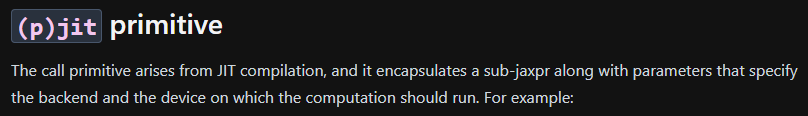

In [11]:
from jax import jit

def func12(arg):
  @jit
  def inner(x):
    return x + arg * jnp.ones(1)  # Include a constant in the inner function.
  return arg + inner(arg - 2.)

print(make_jaxpr(func12)(1.))

{ lambda ; a:f32[]. let
    b:f32[] = sub a 2.0
    c:f32[1] = pjit[
      name=inner
      jaxpr={ lambda ; d:f32[] e:f32[]. let
          f:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 1.0
          g:f32[] = convert_element_type[new_dtype=float32 weak_type=False] d
          h:f32[1] = mul g f
          i:f32[] = convert_element_type[new_dtype=float32 weak_type=False] e
          j:f32[1] = add i h
        in (j,) }
    ] a b
    k:f32[] = convert_element_type[new_dtype=float32 weak_type=False] a
    l:f32[1] = add k c
  in (l,) }


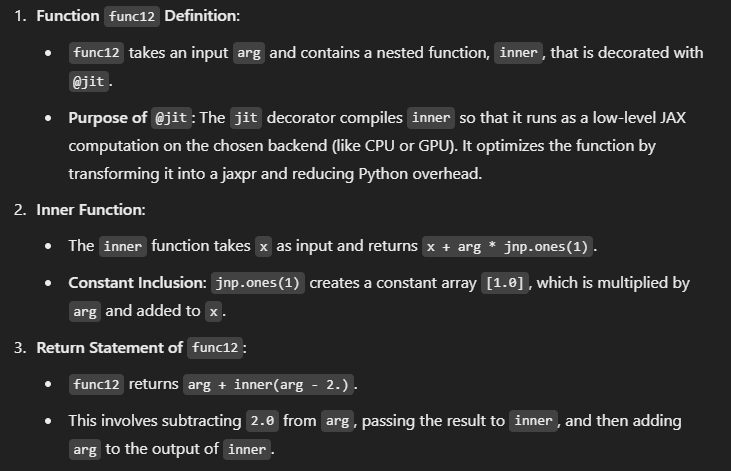

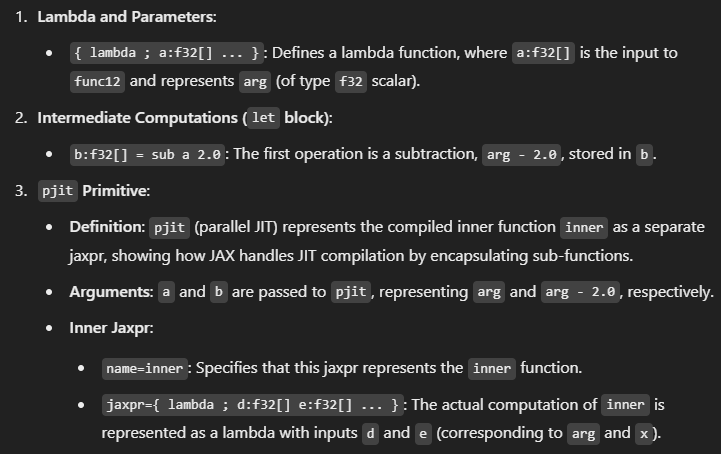

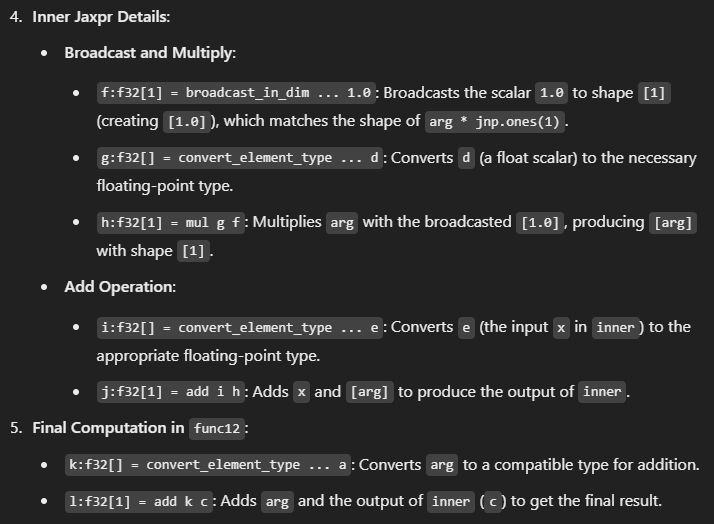